In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ufss
import os
import yaml
import time

## Defining the system

In [3]:
def setup_params(folder,temperature):
    """This function creates the file 'simple_params.yaml' inside the 
        specified folder. The Hamiltonian/Liouvillian Generator (HLG) part of
        ufss needs 'simple_params.yaml' to run.  However, 'simple_params.yaml'
        need not be created using Python. You can skip this function if you 
        would like to make the file in a text editor, or use some other 
        program to make it. yaml files are (ideally) human-readable files
"""
    # everything that is input into the dictionary params (see below) must be
    # a built-in python type. As an example site_energies must by a list of
    # python floats
    
    # the following line means that you will overwrite data inside folder
    # without getting a warning
    os.makedirs(folder,exist_ok=True)

    ### Define Hamiltonian
    site_energies = [0,0] # bare site energies of uncoupled monomers a and b
    site_couplings = [0.5]
    
    # no vibrations
    truncation_size = 1
    vibs = []
    
    ### Define electronic dipoles
    # dipoles are input as a list of cartesian vectors [mu_x, mu_y, mu_z]
    mu = [[1,0,0], # dipole for site a
          [0,1,0]] # dipole for site b

    # This is an ohmic spectral density with two options for a cutoff-function
    site_bath = {'cutoff_frequency':1,# in units of omega_0
                 'coupling':0.05,# system-bath coupling in units of omega_0
                 'temperature':temperature,# kT in units of omega_0
                 'cutoff_function':'lorentz-drude', # other option is 'exponential'
                 'spectrum_type':'ohmic'}
    # Currently the spectral density is real (the imaginary part is not
    # implemented, but certainly could be if you would like to have that)
    # If you want to supply your own spectral density function, that should
    # be no problem, just ask me to show you how

    Redfield_bath = {'secular':False, #set to True if you wish to use secular approximation
                      'site_bath':site_bath}

    params = {
        'site_energies':site_energies,
        'site_couplings':site_couplings,
        'dipoles':mu,
        'truncation_size':truncation_size,
        'vibrations':vibs,
        'bath':Redfield_bath}

    with open(os.path.join(folder,'simple_params.yaml'),'w+') as file_stream:
        yaml.dump(params,file_stream)

    return None

In [4]:
folder = 'vibrationless_dimer'
setup_params(folder,1)
ufss.HLG.run(folder)
uf2 = ufss.DensityMatrices(os.path.join(folder,'open'))

## Figure 4.1

In [5]:
def calculate_linear_absorption(sigma=1,center=0,gamma=0.05):
    
    c = center
    Delta = 10*sigma
    M = 401
    t = np.linspace(-Delta/2,Delta/2,num=M)
    ef = ufss.gaussian(t,sigma)
    uf2.set_efields([t],[ef],[c],[(1,0)])
    uf2.set_pulse_delays([])
    uf2.pulse_times = [0]
    uf2.set_t(gamma,dt=1)

    uf2.set_polarization_sequence(['x'])
    lin_abs_x = uf2.calculate_signal_all_delays()

    uf2.set_polarization_sequence(['y'])
    lin_abs_y = uf2.calculate_signal_all_delays()

    uf2.set_polarization_sequence(['z'])
    lin_abs_z = uf2.calculate_signal_all_delays()

    lin_abs = np.real(lin_abs_x + lin_abs_y + lin_abs_z)/3
    
    return lin_abs

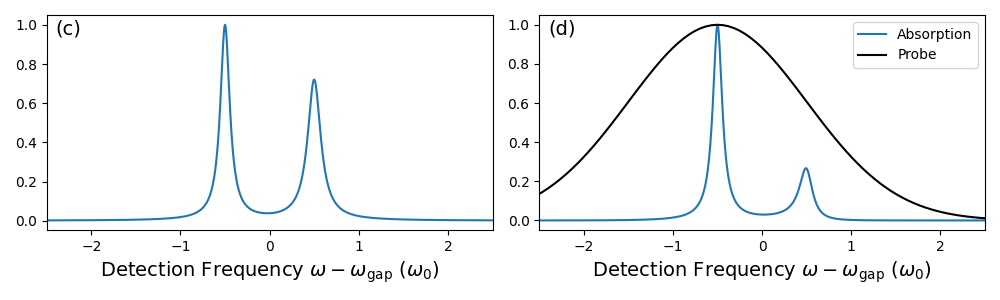

In [7]:
la = calculate_linear_absorption(0.01,0,gamma=0.01)
w = uf2.w.copy()

la2 = calculate_linear_absorption(1,-0.5,gamma=0.01)
w2 = uf2.w.copy()

t = np.arange(-50,50.0001,0.001)
y = ufss.efield_shapes.gaussian(t,1)*np.exp(-1j*0.5*t)

ef_w,ef = ufss.signals.SignalProcessing.ft1D(t,y)

fig, [ax0,ax1] = plt.subplots(1,2,figsize=(10,3))

ax0.plot(w,la/np.max(la))
ax0.set_xlabel('Detection Frequency $\omega-\omega_\mathrm{gap}$ ($\omega_0$)',fontsize=14)
ax0.text(-2.4,0.95,'(c)',fontsize=14)
ax0.set_xlim([-2.5,2.5])

ax1.plot(w2-0.5,la2/np.max(la))
ax1.plot(ef_w,np.real(ef),'-k')
ax1.set_xlabel('Detection Frequency $\omega-\omega_\mathrm{gap}$ ($\omega_0$)',fontsize=14)
ax1.text(-2.4,0.95,'(d)',fontsize=14)
ax1.set_xlim([-2.5,2.5])
ax1.legend(['Absorption','Probe'])
fig.tight_layout()
#fig.savefig('DimerLinearAbsorptionDifferentPulseShapes.pdf')

## Figure 4.2

In [8]:
def calculate_transient_absorption(sigma=1,center=0,gamma=0.05,delay_times = np.arange(0,100,1)):
    
    c = center
    Delta = 10*sigma
    M = 41
    t = np.linspace(-Delta/2,Delta/2,num=41)
    ef = ufss.gaussian(t,sigma)
    uf2.set_efields([t]*4,[ef]*4,[c]*4,['-','+','+'])
    uf2.set_pulse_delays([np.array([0]),delay_times])
    uf2.set_t(gamma,dt=1)

    uf2.set_polarization_sequence(['x']*4)
    
    iso = ufss.signals.FWMIsotropicAverage(uf2,['x']*4)
    
    signal = iso.averaged_signal(return_signal=True)
    
    return signal

In [9]:
t0 = time.time()
ta = calculate_transient_absorption(sigma=1,center=0,gamma=0.05)
T = uf2.all_pulse_delays[1].copy()
w = uf2.w.copy()
print(time.time() - t0)
ta_final = calculate_transient_absorption(sigma=1,center=0,gamma=0.05,delay_times = np.array([1000]))
ta_final.shape

8.898555278778076


(1, 1, 277)

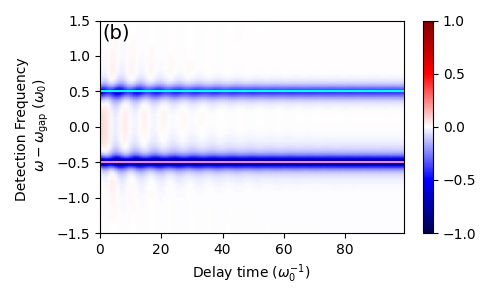

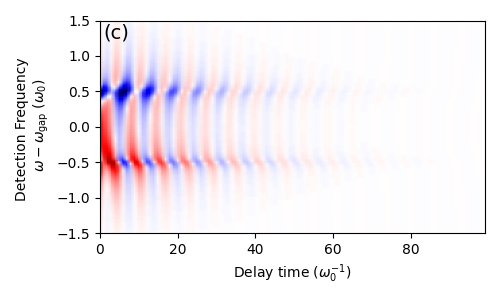

In [10]:
fig1, ax0 = plt.subplots(1,figsize=(5,3))

ufss.signals.plot2D(T,w,ta[0,:,:]/np.max(np.abs(ta[0,:,:])),part='real',
                   fig = fig, ax = ax0,colorbar=True)
ax0.set_ylabel('Detection Frequency \n $\omega-\omega_\mathrm{gap}$ ($\omega_0$)')
ax0.axhline(y=0.5,color='cyan')
ax0.axhline(y=-0.5,color='violet')
ax0.set_xlabel('Delay time ($\omega_0^{-1}$)')
ax0.set_ylim([-1.5,1.5])
ax0.text(1,1.25,'(b)',fontsize=14)
fig1.tight_layout()

fig2, ax1 = plt.subplots(1,figsize=(5,3))
ufss.signals.plot2D(T,w,ta[0,:,:]-ta_final[0,-1,:][np.newaxis,:],part='real',
                   fig = fig, ax = ax1,colorbar=False)
ax1.set_ylabel('Detection Frequency \n $\omega-\omega_\mathrm{gap}$ ($\omega_0$)')
ax1.set_xlabel('Delay time ($\omega_0^{-1}$)')
ax1.set_ylim([-1.5,1.5])
ax1.text(1,1.25,'(c)',fontsize=14)
fig2.tight_layout()

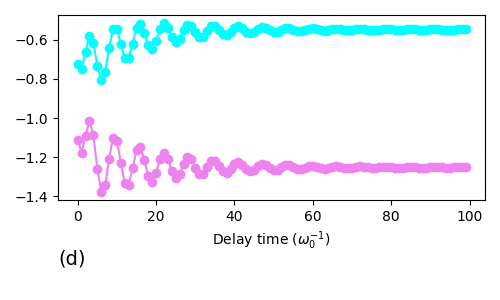

In [11]:
plt.figure(figsize=(5,3))
ind1 = np.argmin(np.abs(w-0.5))
y1 = np.real(ta[0,:,ind1])
ind2 = np.argmin(np.abs(w+0.5))
y2 = np.real(ta[0,:,ind2])
plt.plot(T,y1,'-o',color='cyan')
plt.plot(T,y2,'-o',color='violet')
plt.xlabel('Delay time ($\omega_0^{-1}$)')
plt.text(-5,-1.75,'(d)',fontsize=14)
plt.tight_layout()
#ax = plt.gca()
#ax.yaxis.set_ticks([])

## Figure 4.3

In [11]:
def inhomogeneous_broadening(spec_fun,sigma_broadening,**kwargs):
    spec_fun(**kwargs)
    sb = sigma_broadening
    dw = uf2.w[1] - uf2.w[0]
    centers = np.arange(-sb*3,sb*3,dw)
    print('Averaging over {} simulations'.format(centers.size))
    weights = ufss.gaussian(centers,sb)
    signal = spec_fun(center=centers[0],**kwargs)
    signals = np.zeros((centers.size,*signal.shape),dtype='complex')
    for i in range(centers.size):
        signals[i,...] = spec_fun(center=centers[i],**kwargs)
        
    signal = np.einsum('i,i...',weights,signals)/weights.sum()
    return signal

Averaging over 33 simulations


<IPython.core.display.Javascript object>


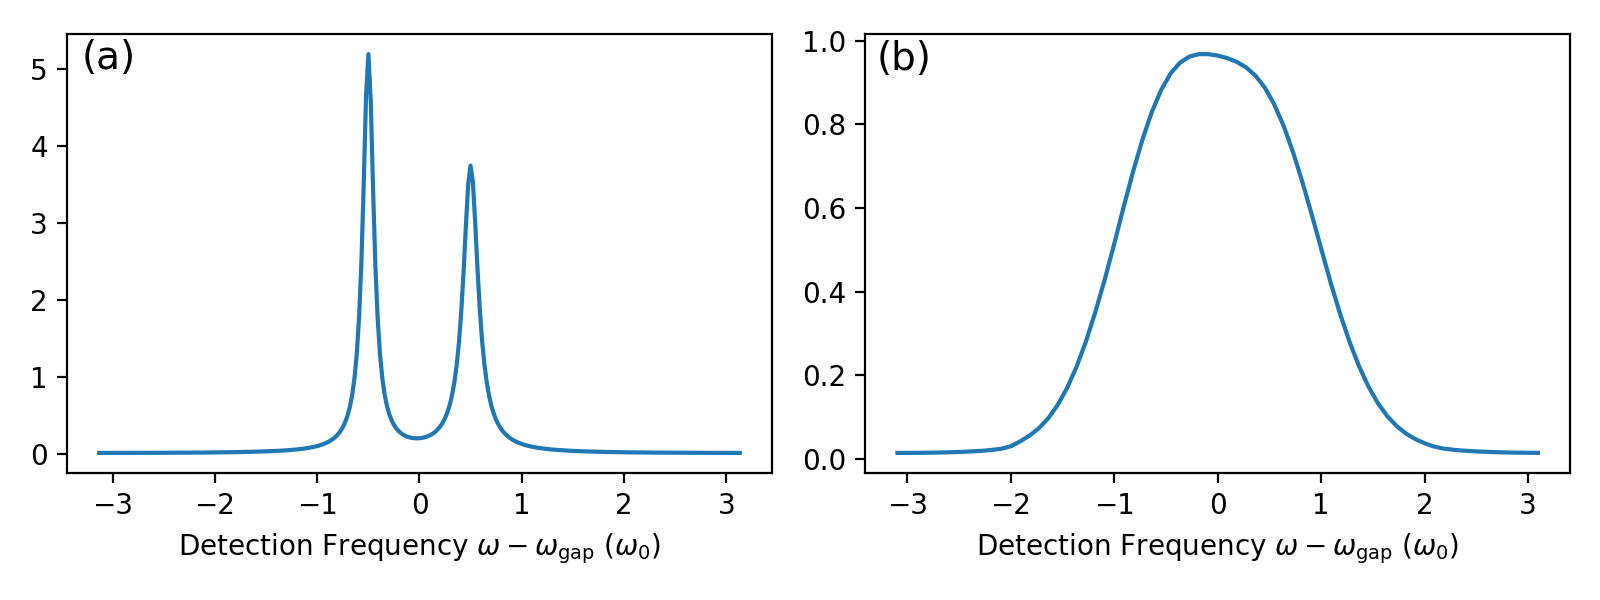

In [12]:
la = calculate_linear_absorption(0.0001,0,gamma=0.05)
w = uf2.w.copy()

la_broadened = inhomogeneous_broadening(calculate_linear_absorption,0.5,sigma=0.0001,gamma=0.2)
w2 = uf2.w.copy()

fig, [ax0,ax1] = plt.subplots(1,2,figsize=(8,3))

ax0.plot(w,np.real(la))
ax0.set_xlabel('Detection Frequency $\omega-\omega_\mathrm{gap}$ ($\omega_0$)')
ax0.text(-3.3,5,'(a)',fontsize=14)

ax1.plot(w2,np.real(la_broadened))
ax1.set_xlabel('Detection Frequency $\omega-\omega_\mathrm{gap}$ ($\omega_0$)')
ax1.text(-3.3,0.93,'(b)',fontsize=14)
fig.tight_layout()
fig.savefig('DimerLinearAbsorption.pdf')

## Figure 4.4

In [13]:
def calculate_2PPE(sigma=1,center=0,gamma=0.05):
    
    c = center
    Delta = 6*sigma
    M = 25
    t = np.linspace(-Delta/2,Delta/2,num=M)*sigma
    ef = ufss.gaussian(t,sigma)
    uf2.set_efields([t]*4,[ef]*4,[c]*4,[(0,1),(1,0),(1,0)])
    uf2.set_t(gamma,dt=1)
    tau = uf2.t.copy()[uf2.t.size//2:]
    
    uf2.set_pulse_delays([tau,np.array([0])])
    

    uf2.set_polarization_sequence(['x']*4)
    
    uf2.return_complex_signal = True
    
    iso = ufss.signals.FWMIsotropicAverage(uf2,['x']*4)
    
    signal = iso.averaged_signal(return_signal=True)
    
    return signal

In [14]:
t0 = time.time()
tppe = calculate_2PPE(center = 0,sigma=1,gamma=0.1)
print(time.time() - t0)

5.419512987136841


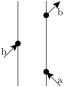

In [15]:
uf2.display_diagram([('Bu',0),('Ku',1),('Bd',1)])
#panel b

<IPython.core.display.Javascript object>


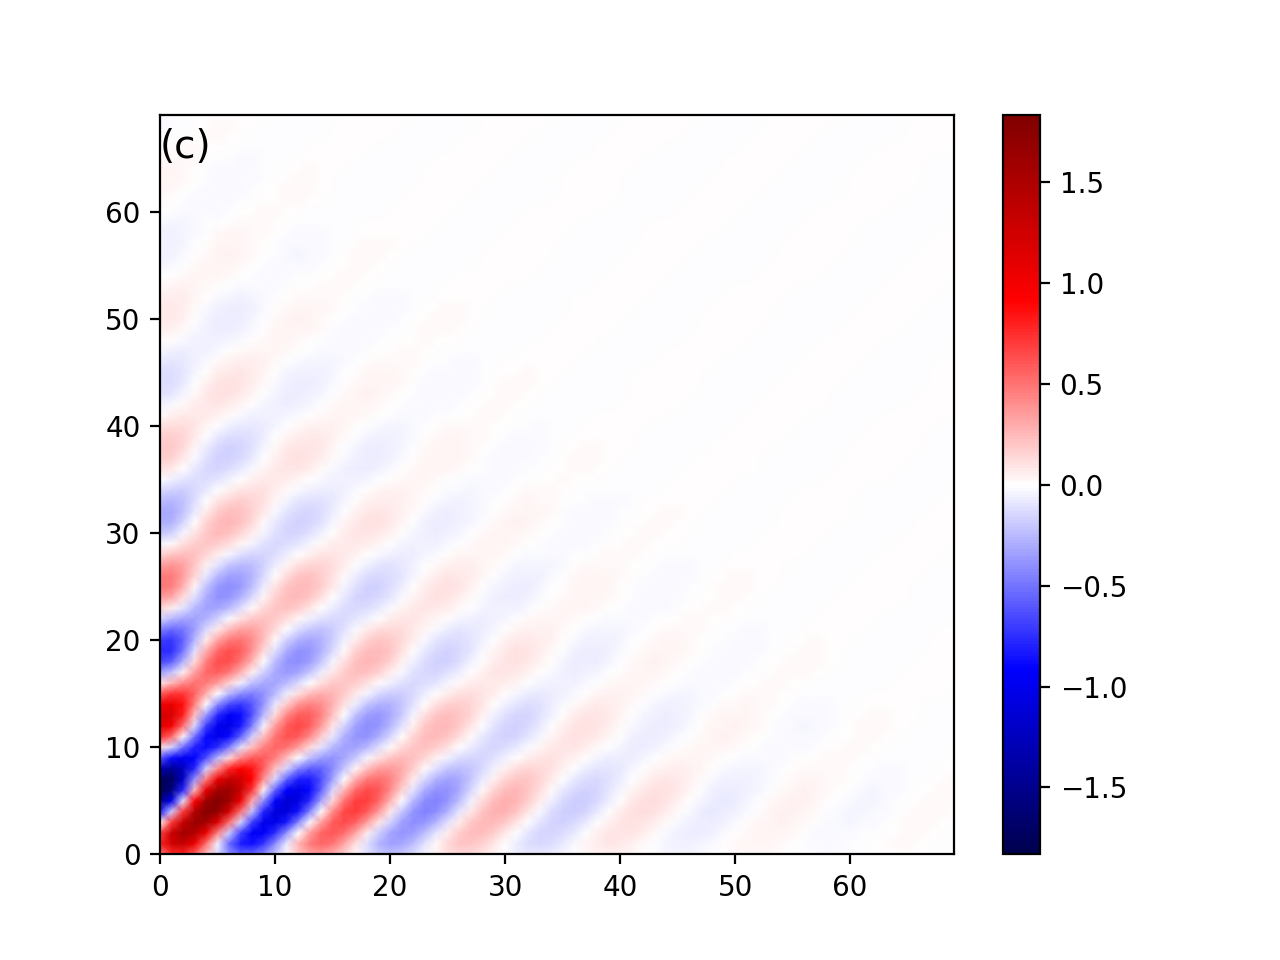

<IPython.core.display.Javascript object>


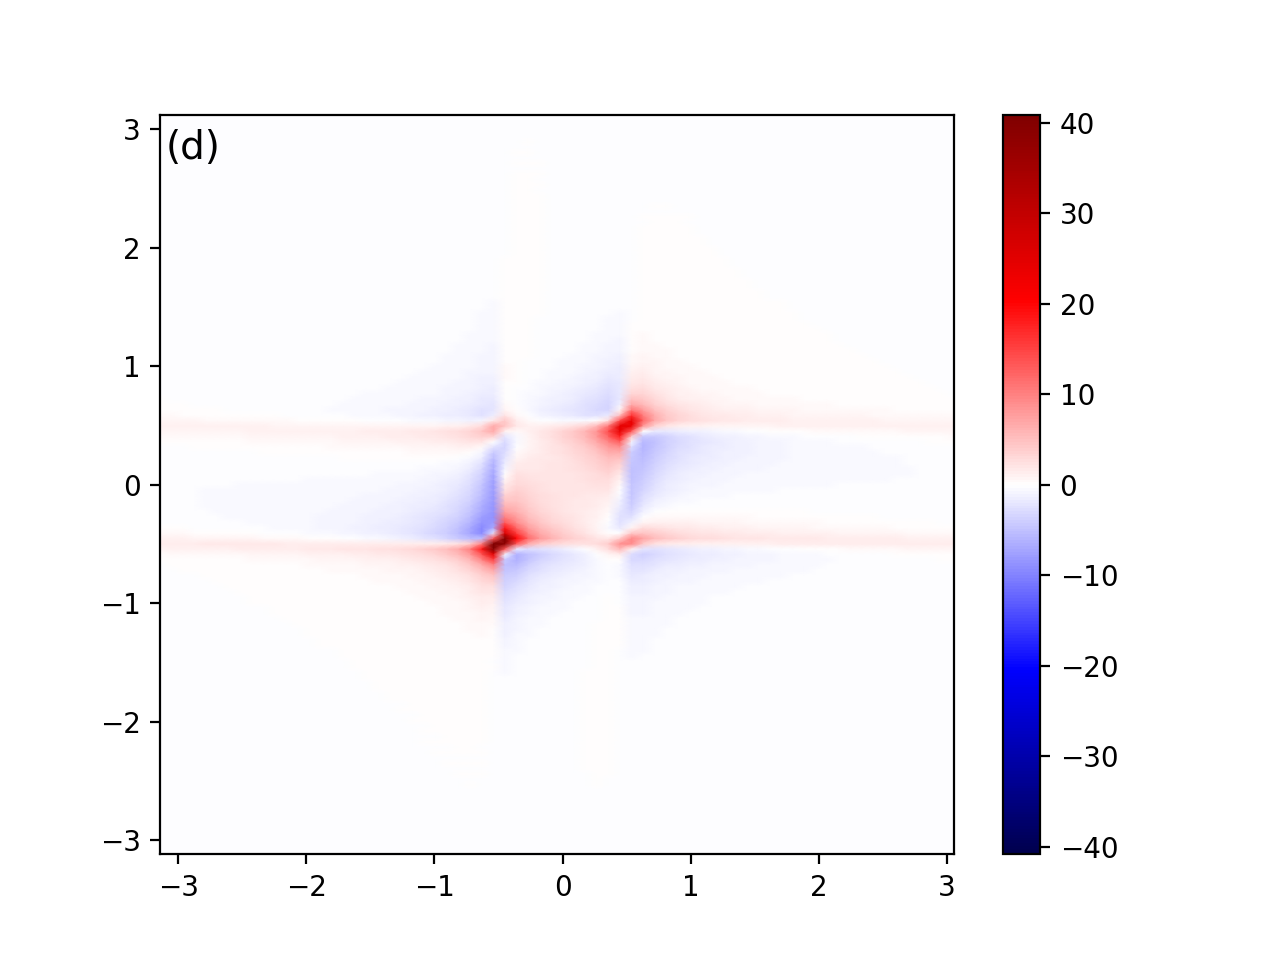

Text(-3.1, 2.75, '(d)')

In [16]:
tau = uf2.all_pulse_delays[0]
wtau, tppe_ft = ufss.signals.SignalProcessing.ft1D(tau,tppe,axis=0)
t, tppe_ift = ufss.signals.SignalProcessing.ft1D(uf2.w,tppe,axis=-1)
ufss.signals.plot2D(tau,t,tppe_ift[:,0,:],part='real')
plt.text(0,65,'(c)',fontsize=14)
plt.ylim([0,np.max(t)])
ufss.signals.plot2D(wtau,uf2.w,tppe_ft[:,0,:],part='real')
plt.text(-3.1,2.75,'(d)',fontsize=14)


In [17]:
t0 = time.time()
tppe_broadened = inhomogeneous_broadening(calculate_2PPE,0.4,sigma=1,gamma=0.1)
print(time.time() - t0)


Averaging over 54 simulations
294.1626501083374


<IPython.core.display.Javascript object>


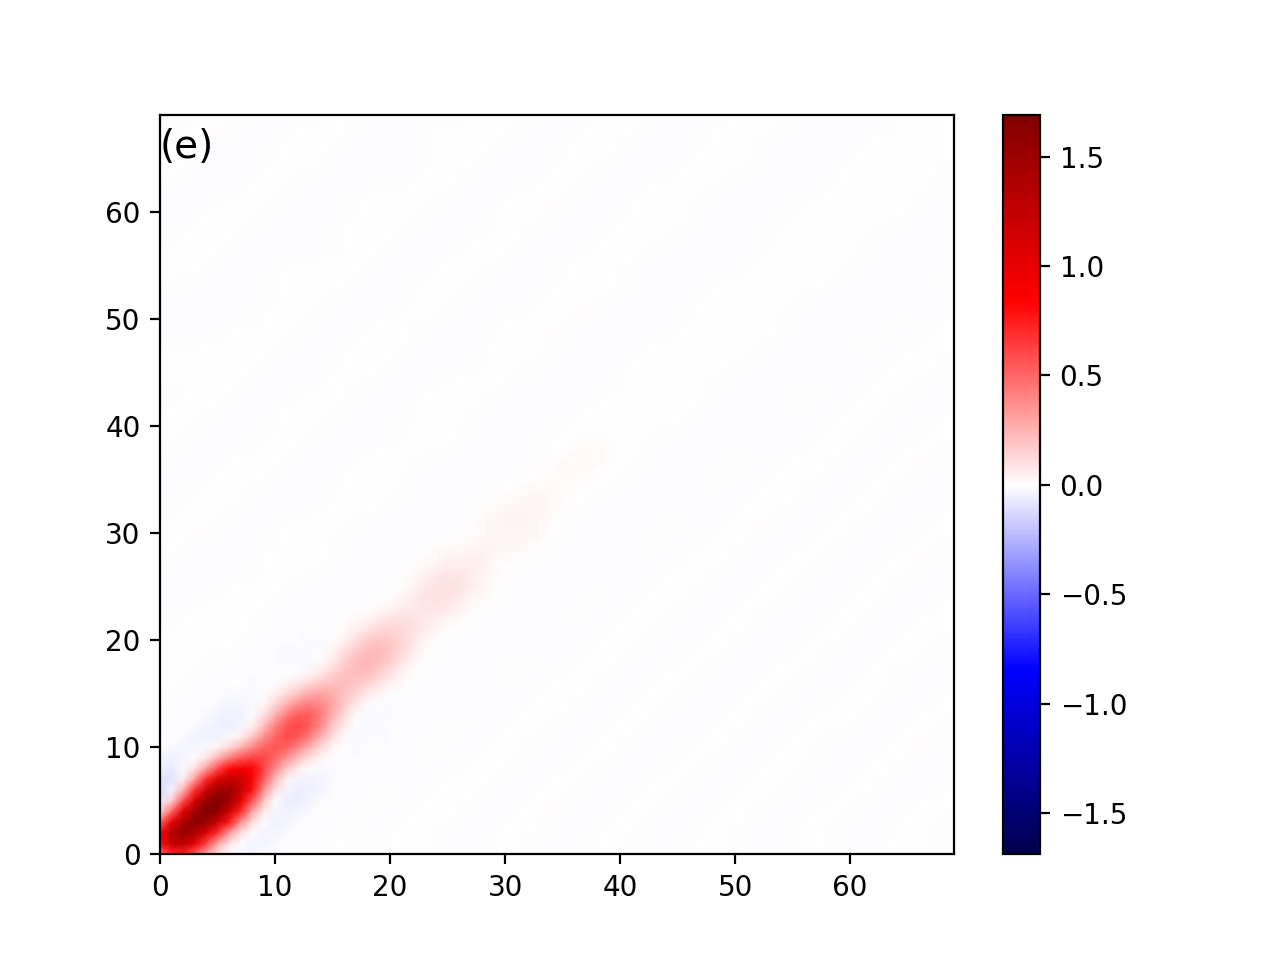

<IPython.core.display.Javascript object>


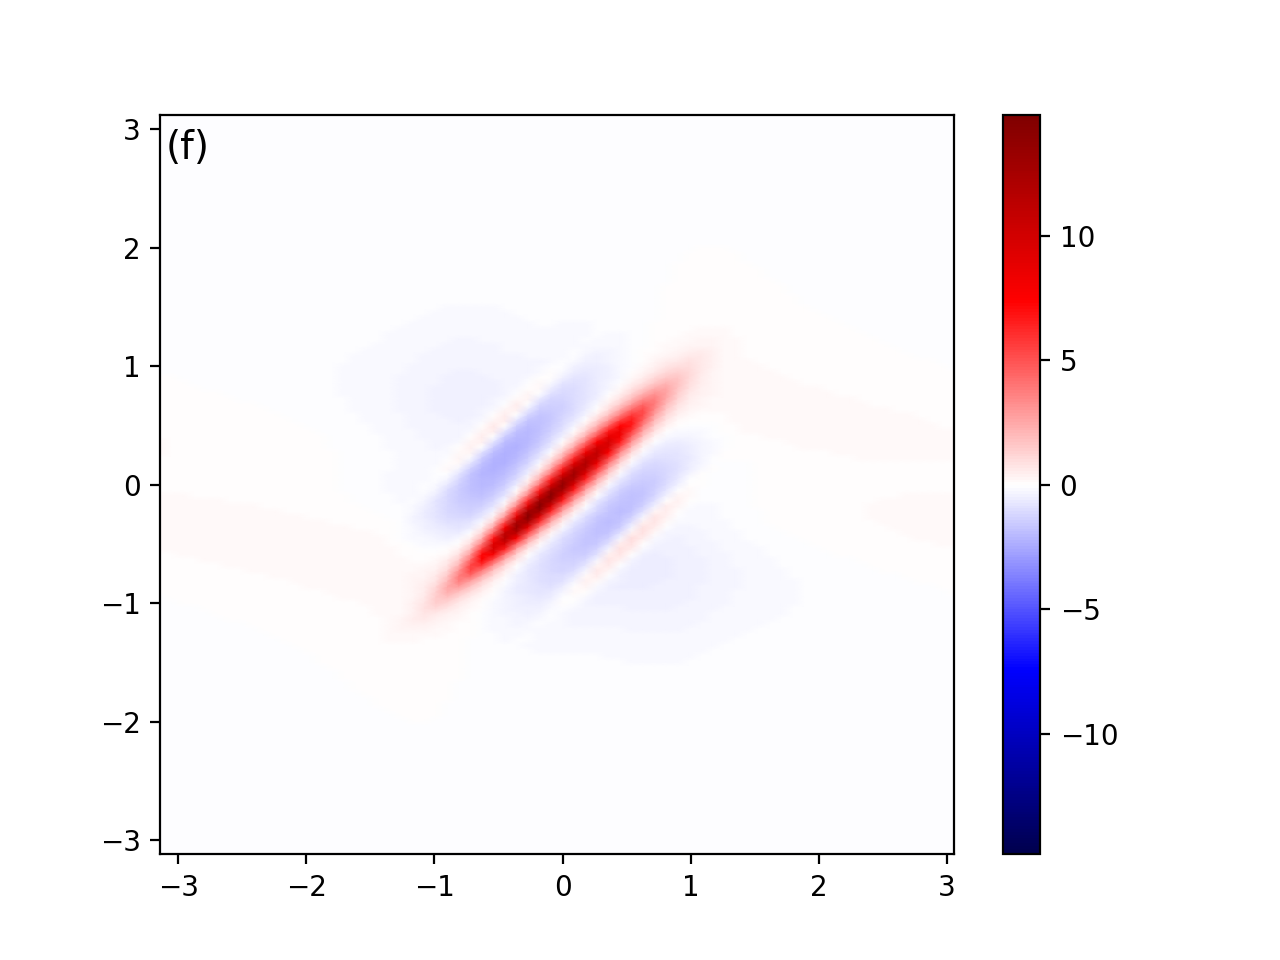

Text(-3.1, 2.75, '(f)')

In [18]:
tau = uf2.all_pulse_delays[0]
wtau, tppe_ft = ufss.signals.SignalProcessing.ft1D(tau,tppe_broadened,axis=0)
t, tppe_ift = ufss.signals.SignalProcessing.ft1D(uf2.w,tppe_broadened,axis=-1)
ufss.signals.plot2D(tau,t,tppe_ift[:,0,:],part='real')
plt.text(0,65,'(e)',fontsize=14)
plt.ylim([0,np.max(t)])
ufss.signals.plot2D(wtau,uf2.w,tppe_ft[:,0,:],part='real')
plt.text(-3.1,2.75,'(f)',fontsize=14)


## Figure 4.5

In [19]:
def calculate_2DPE_r(sigma=1,center=0,gamma=0.05,delay_times = np.array([100])*np.pi):
    
    centers = [center]*4
    Delta = 6*sigma
    M = 25
    t = np.linspace(-Delta/2,Delta/2,num=M)
    ef = ufss.gaussian(t,sigma)
    uf2.set_efields([t]*4,[ef]*4,centers,['-','+','+'])
    uf2.set_t(gamma,dt=1)
    tau = uf2.t.copy()[uf2.t.size//2:]

    uf2.set_pulse_delays([tau,delay_times])
    

    uf2.set_polarization_sequence(['x']*4)
    
    uf2.return_complex_signal = True
    
    iso = ufss.signals.FWMIsotropicAverage(uf2,['x']*4)
    
    signal = iso.averaged_signal(return_signal=True)
    
    return signal


In [20]:
def calculate_2DPE_nr(sigma=1,center=0,gamma=0.05,delay_times = np.array([100])*np.pi):
    
    centers = [center]*4
    Delta = 6*sigma
    M = 25
    t = np.linspace(-Delta/2,Delta/2,num=M)
    ef = ufss.gaussian(t,sigma)
    uf2.set_efields([t]*4,[ef]*4,centers,['+','-','+'])
    uf2.set_t(gamma,dt=1)
    tau = uf2.t.copy()[uf2.t.size//2:]

    uf2.set_pulse_delays([tau,delay_times])
    

    uf2.set_polarization_sequence(['x']*4)
    
    uf2.return_complex_signal = True
    
    iso = ufss.signals.FWMIsotropicAverage(uf2,['x']*4)
    
    signal = iso.averaged_signal(return_signal=True)
    
    return signal

In [21]:
folder = 'vibrationless_dimer/'
uf2 = ufss.DensityMatrices(os.path.join(folder,'open'))

#Delay times
T = np.arange(0,1)


In [22]:
t0 = time.time()
tdpe_r_broadened = inhomogeneous_broadening(calculate_2DPE_r,0.1,sigma=1,gamma=0.1,delay_times=np.array([0]))
print(time.time() - t0)
taur = uf2.all_pulse_delays[0].copy()
wr = uf2.w.copy()

t0 = time.time()
tdpe_nr_broadened = inhomogeneous_broadening(calculate_2DPE_nr,0.1,sigma=1,gamma=0.1,delay_times=np.array([0]))
print(time.time() - t0)
taunr = uf2.all_pulse_delays[0].copy()
wnr = uf2.w.copy()

Averaging over 14 simulations
84.9971010684967
Averaging over 14 simulations
72.05854105949402


<IPython.core.display.Javascript object>


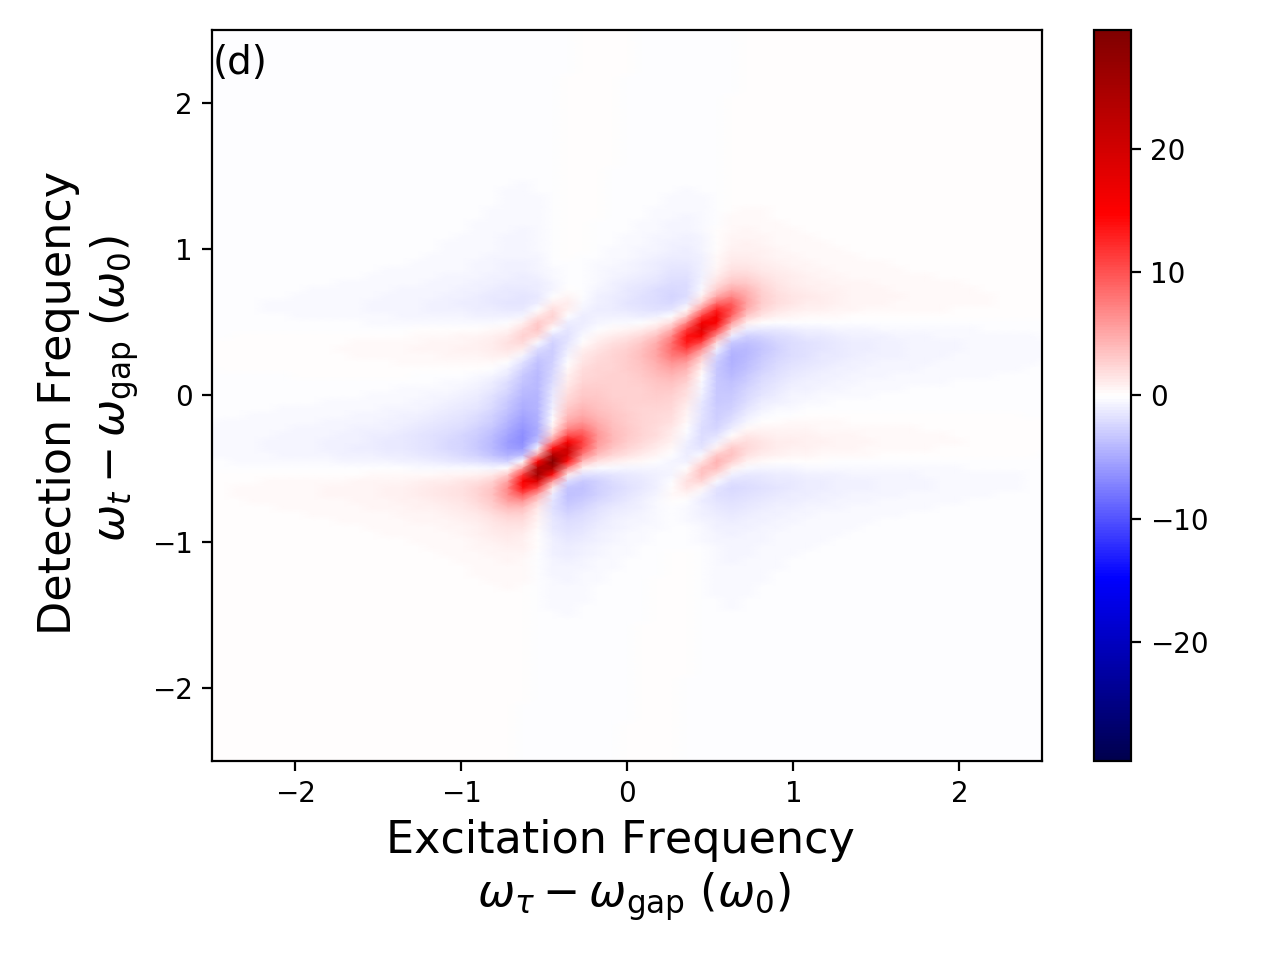

In [23]:
tdpe_r_broadened_for_ft = tdpe_r_broadened.copy()
tdpe_r_broadened_for_ft[0,...] *= 0.5
wtaur, tdpe_r_broadened_ft = ufss.signals.SignalProcessing.ft1D(taur,tdpe_r_broadened_for_ft,axis=0)
tdpe_r_broadened_ft = tdpe_r_broadened_ft
ufss.signals.plot2D(wtaur,wr,tdpe_r_broadened_ft[:,0,:],part='real')
plt.xlim([-2.5,2.5])
plt.ylim([-2.5,2.5])
plt.xlabel('Excitation Frequency \n $\omega_\\tau-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.ylabel('Detection Frequency \n $\omega_t-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.text(-2.5,2.2,'(d)',fontsize=14)
plt.tight_layout()

<IPython.core.display.Javascript object>


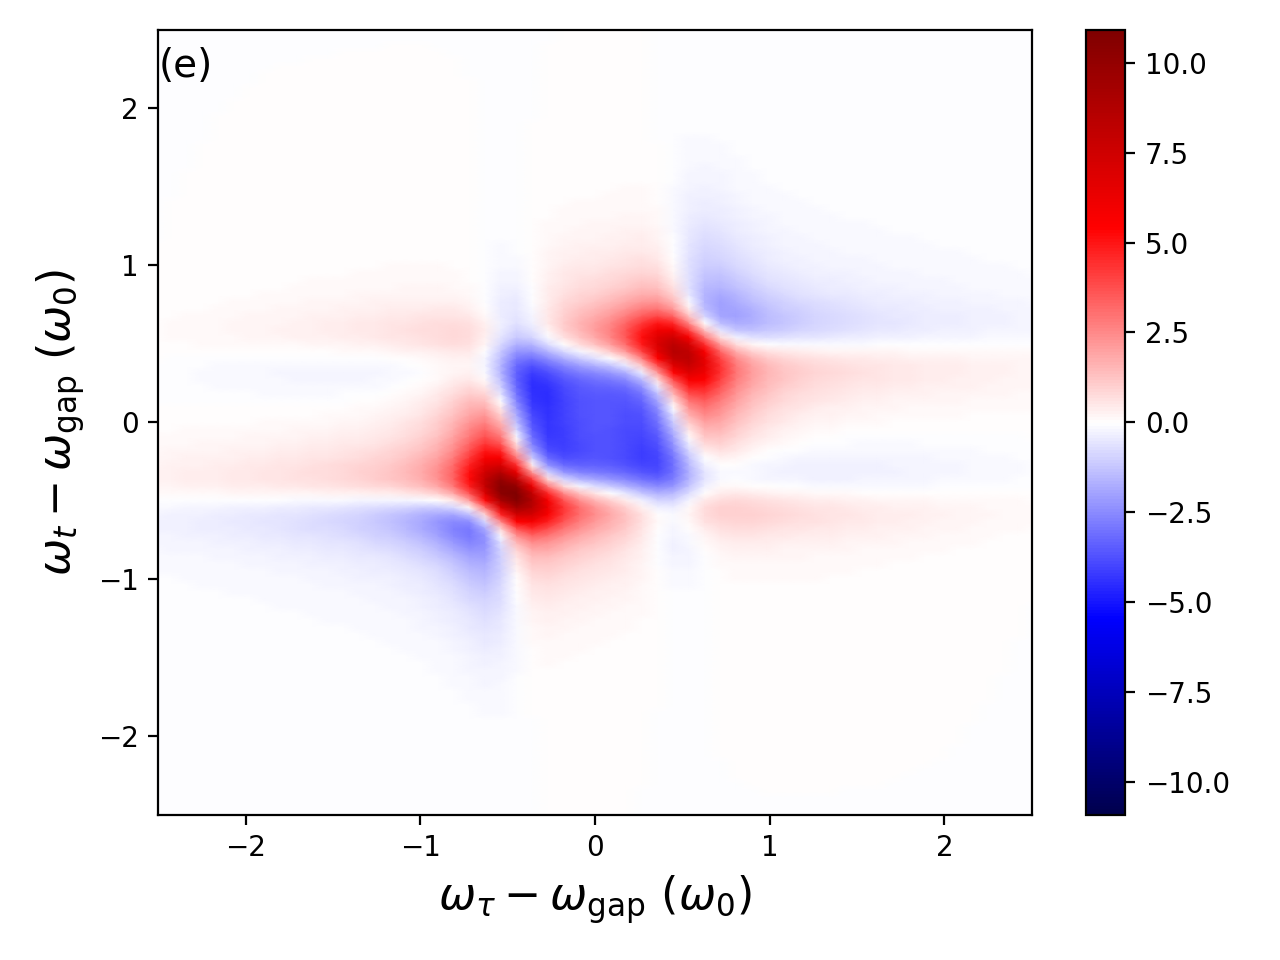

In [24]:
tdpe_nr_broadened_for_ft = tdpe_nr_broadened.copy()
tdpe_nr_broadened_for_ft[0,...] *= 0.5
wtaunr, tdpe_nr_broadened_ft = ufss.signals.SignalProcessing.ift1D(taur,tdpe_nr_broadened_for_ft,axis=0)
tdpe_nr_broadened_ft *= 2*np.pi
ufss.signals.plot2D(wtaunr,wr,tdpe_nr_broadened_ft[:,0,:],part='real')
plt.xlim([-2.5,2.5])
plt.ylim([-2.5,2.5])
plt.xlabel(r'$\omega_\tau-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.ylabel('$\omega_t-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.text(-2.5,2.2,'(e)',fontsize=14)
plt.tight_layout()

<IPython.core.display.Javascript object>


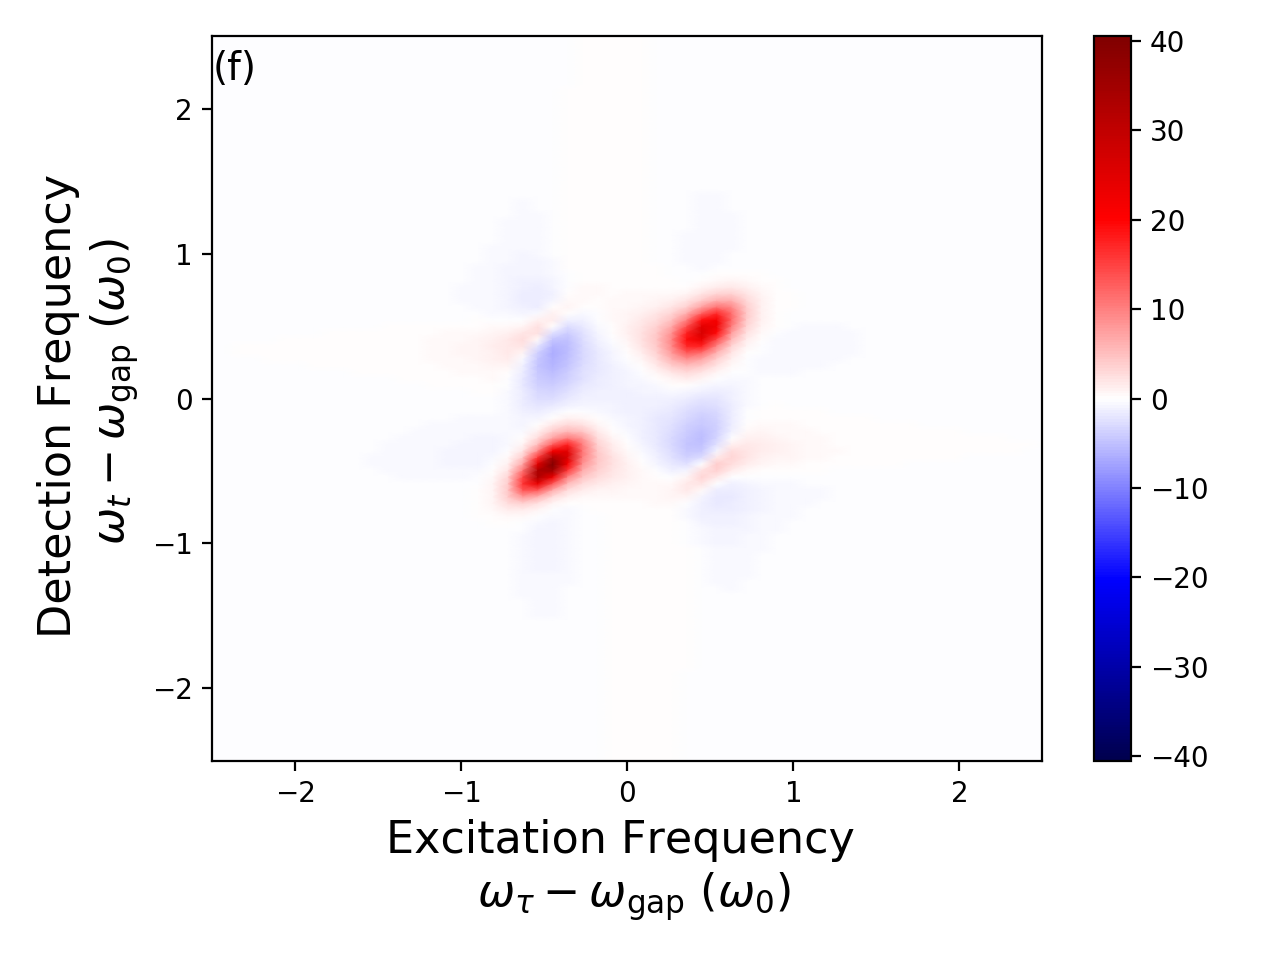

In [25]:
ufss.signals.plot2D(wtaur,wr,tdpe_nr_broadened_ft[:,0,:]+tdpe_r_broadened_ft[:,0,:],part='real')
plt.xlim([-2.5,2.5])
plt.ylim([-2.5,2.5])
plt.xlabel('Excitation Frequency \n $\omega_\\tau-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.ylabel('Detection Frequency \n $\omega_t-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.text(-2.5,2.2,'(f)',fontsize=14)
plt.tight_layout()

In [26]:
t0 = time.time()
tdpe_r = calculate_2DPE_r(center=0,sigma=1,gamma=0.1,delay_times=T)
calc_time = time.time() - t0
print(calc_time)
taur = uf2.all_pulse_delays[0].copy()
wr = uf2.w.copy()

t0 = time.time()
tdpe_nr = calculate_2DPE_nr(center=0,sigma=1,gamma=0.1,delay_times=T)
calc_time = time.time() - t0
print(calc_time)
taunr = uf2.all_pulse_delays[0].copy()
wnr = uf2.w.copy()


5.255023241043091
4.567827939987183


<IPython.core.display.Javascript object>


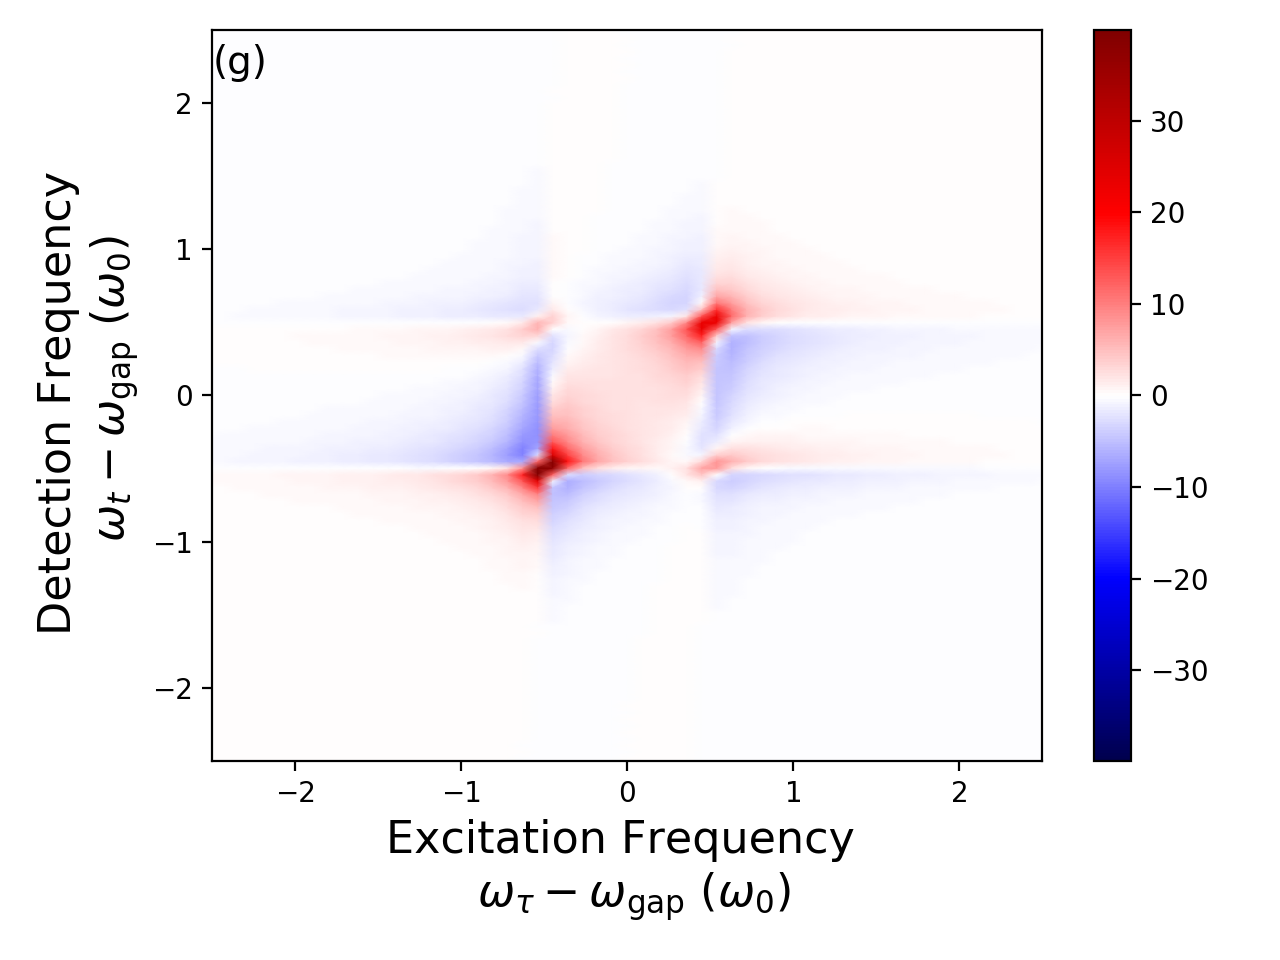

In [27]:
tdpe_r_for_ft = tdpe_r.copy()
tdpe_r_for_ft[0,...] *= 0.5
wtaur, tdpe_r_ft = ufss.signals.SignalProcessing.ft1D(taur,tdpe_r_for_ft,axis=0)
ufss.signals.plot2D(wtaur,wr,tdpe_r_ft[:,0,:],part='real')
plt.xlim([-2.5,2.5])
plt.ylim([-2.5,2.5])
plt.xlabel('Excitation Frequency \n $\omega_\\tau-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.ylabel('Detection Frequency \n $\omega_t-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.text(-2.5,2.2,'(g)',fontsize=14)
plt.tight_layout()

<IPython.core.display.Javascript object>


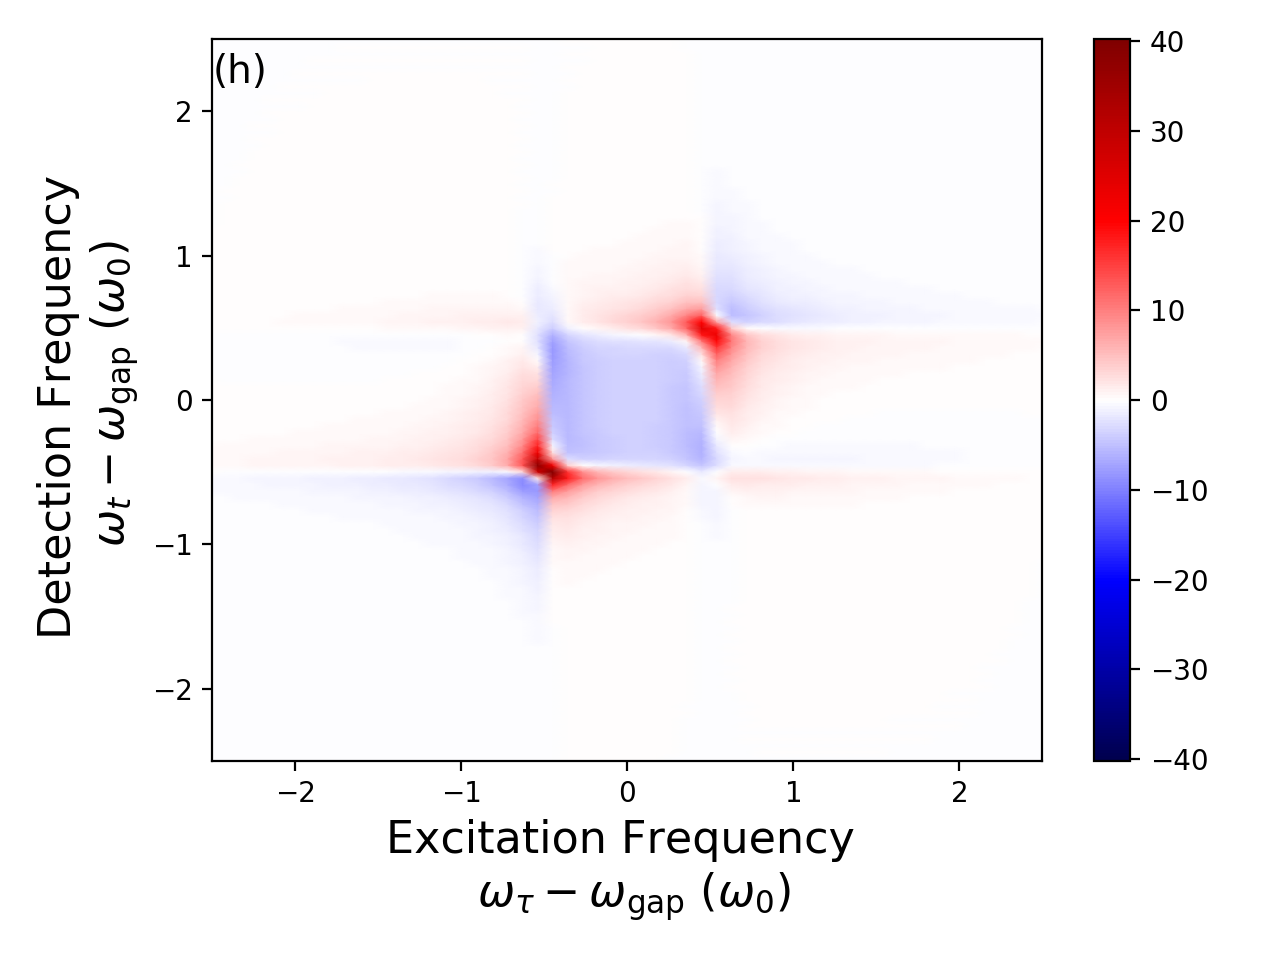

In [28]:
tdpe_nr_for_ft = tdpe_nr.copy()
tdpe_nr_for_ft[0,...] *= 0.5
wtaur, tdpe_nr_ft = ufss.signals.SignalProcessing.ift1D(taur,tdpe_nr_for_ft,axis=0)
tdpe_nr_ft *= 2*np.pi
ufss.signals.plot2D(wtaunr,wnr,tdpe_nr_ft[:,0,:],part='real')
plt.xlim([-2.5,2.5])
plt.ylim([-2.5,2.5])
plt.xlabel('Excitation Frequency \n $\omega_\\tau-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.ylabel('Detection Frequency \n $\omega_t-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.text(-2.5,2.2,'(h)',fontsize=14)
plt.tight_layout()

<IPython.core.display.Javascript object>


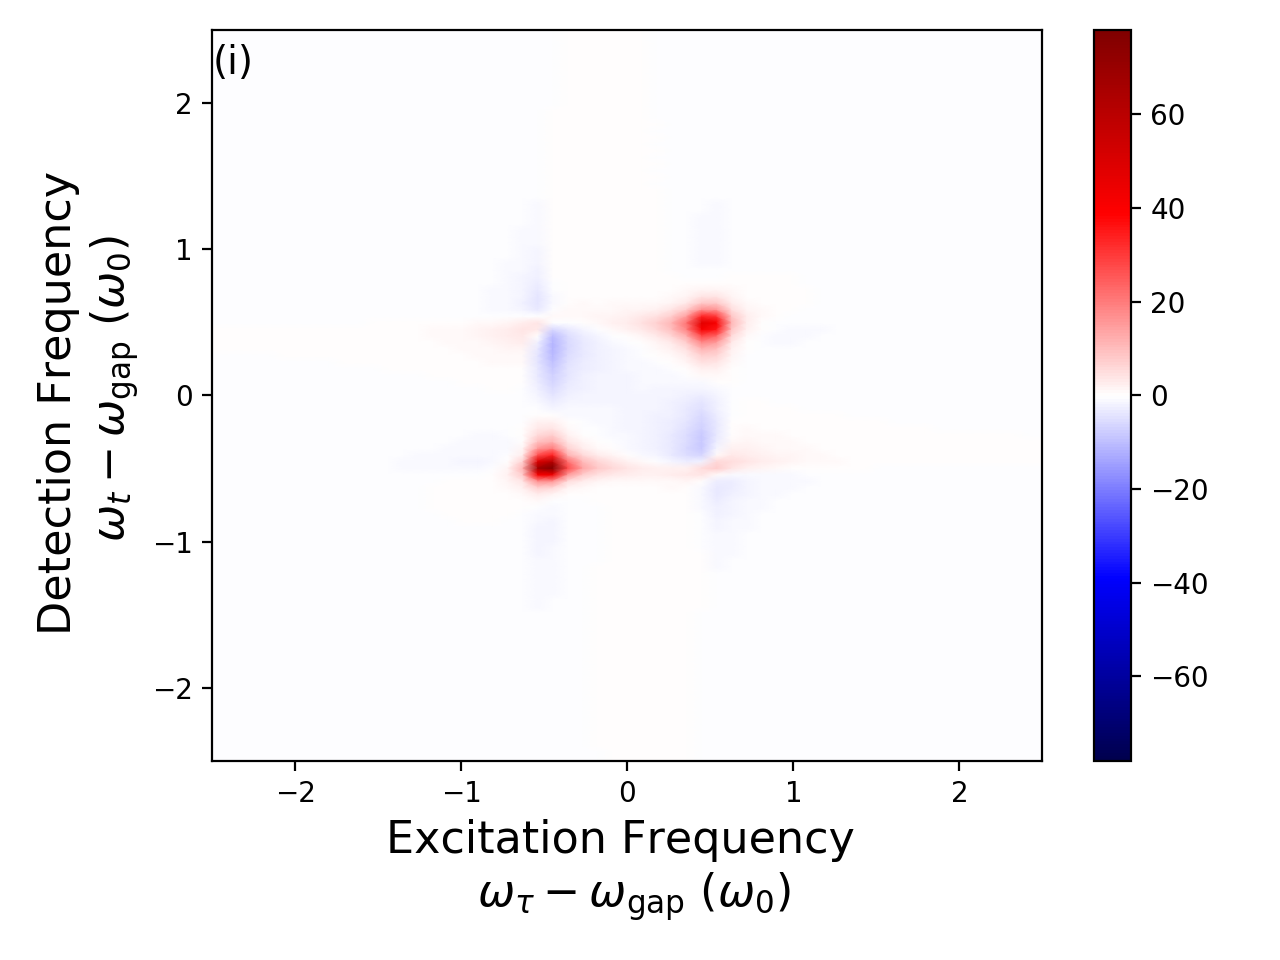

In [29]:
ufss.signals.plot2D(wtaunr,wnr,tdpe_nr_ft[:,0,:]+tdpe_r_ft[:,0,:],part='real')
plt.xlim([-2.5,2.5])
plt.ylim([-2.5,2.5])
plt.xlabel('Excitation Frequency \n $\omega_\\tau-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.ylabel('Detection Frequency \n $\omega_t-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.text(-2.5,2.2,'(i)',fontsize=14)
plt.tight_layout()

## Figure 4.6

Panels a-c are at the bottom, after d-f

In [30]:
folder = 'vibrationless_dimer/'
uf2 = ufss.DensityMatrices(os.path.join(folder,'open'))

T = np.arange(0,100)*np.pi/4

t0 = time.time()
tdpe_r = calculate_2DPE_r(center=0,sigma=1,gamma=0.1,delay_times=T)
calc_time = time.time() - t0
print(calc_time)
taur = uf2.all_pulse_delays[0].copy()
wr = uf2.w.copy()

226.91751718521118


<IPython.core.display.Javascript object>


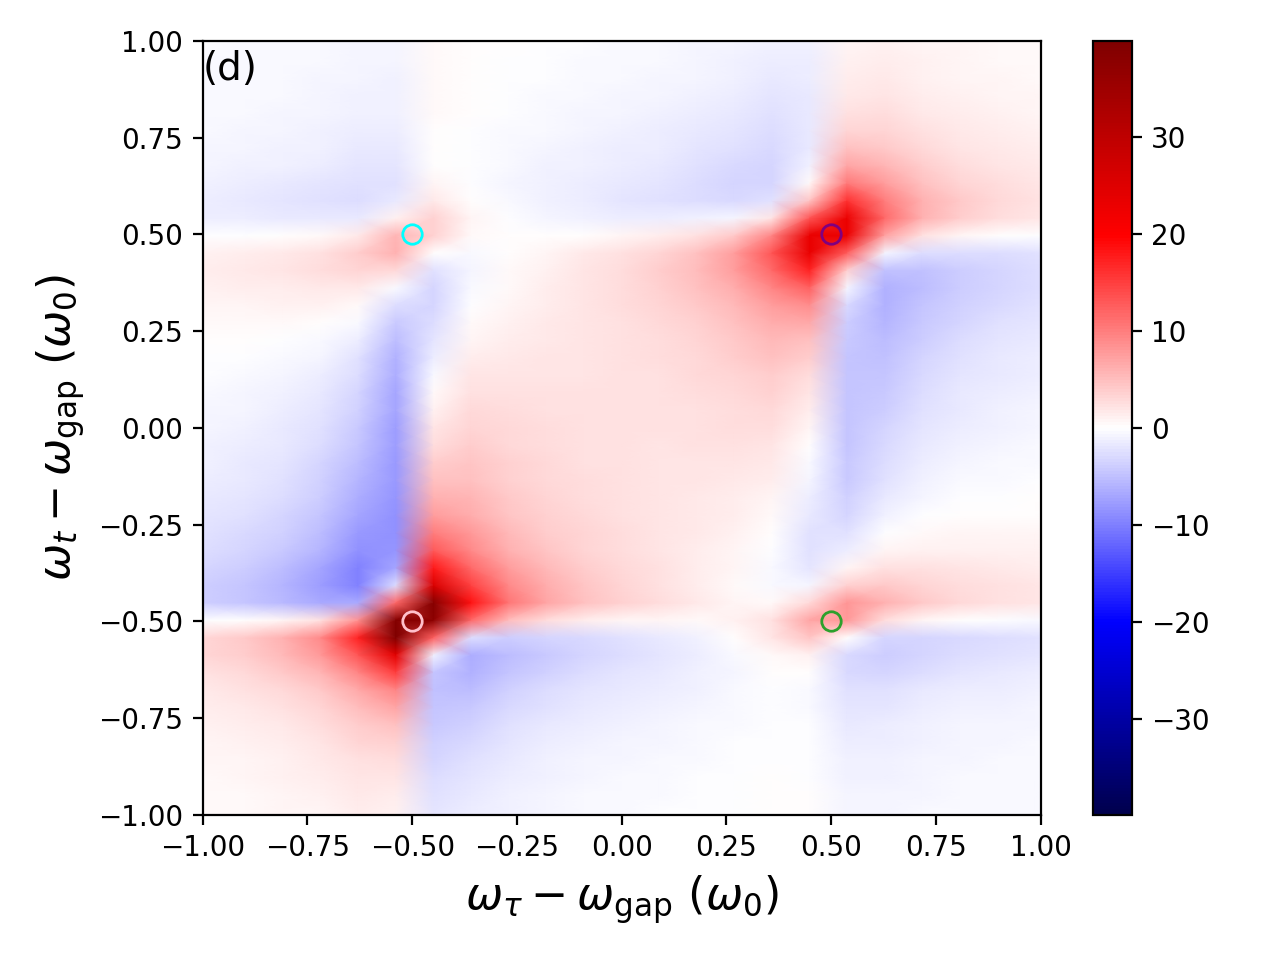

<IPython.core.display.Javascript object>


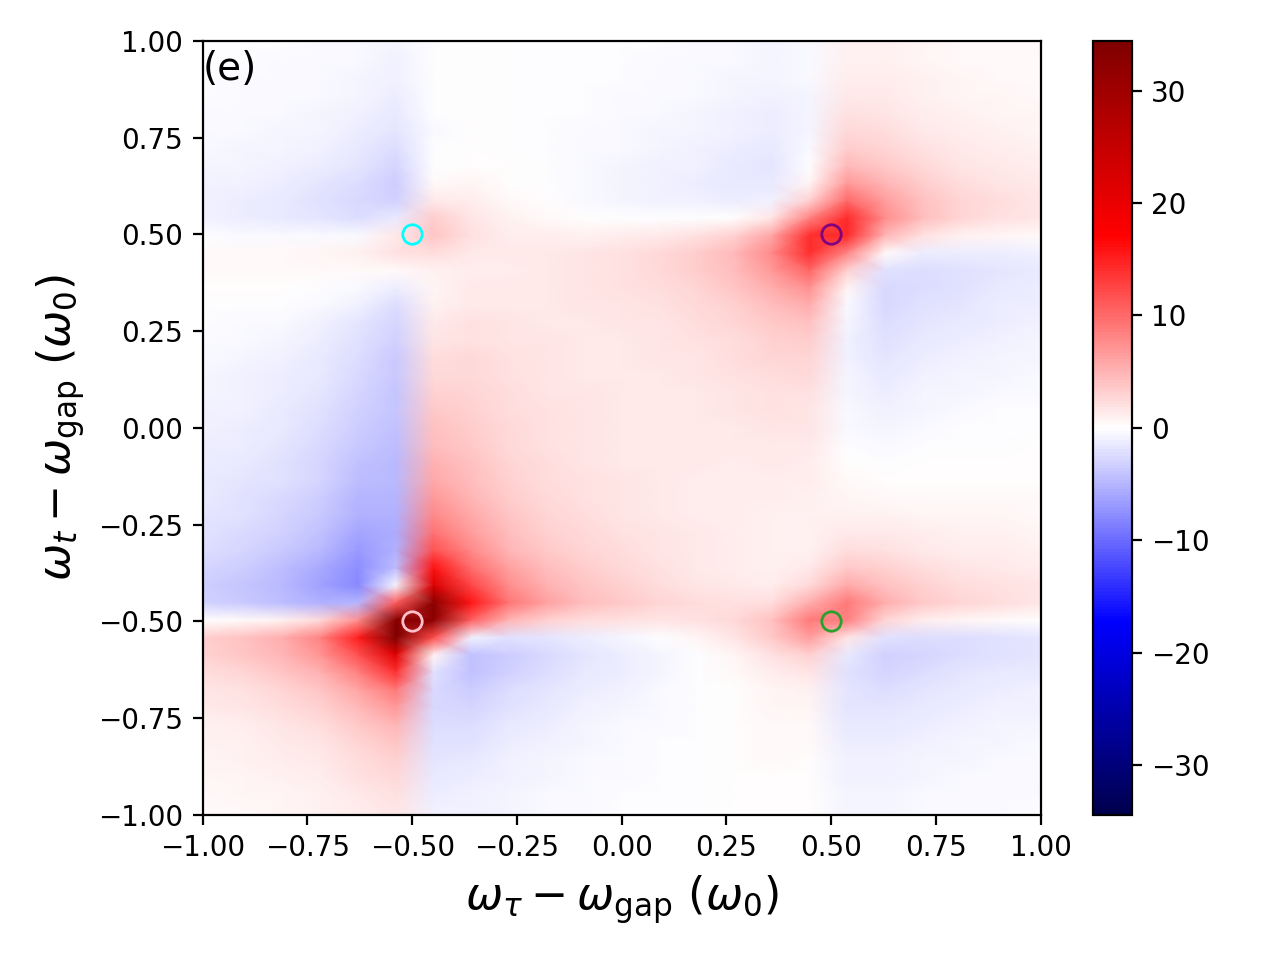

In [31]:
tdpe_r_for_ft = tdpe_r.copy()
tdpe_r_for_ft[0,...] *= 0.5
wtaur, tdpe_r_ft = ufss.signals.SignalProcessing.ft1D(taur,tdpe_r_for_ft,axis=0)

z = tdpe_r_ft
T_ind = 0
ufss.signals.plot2D(wtaur,wr,z[:,T_ind,:],part='real')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.plot(-0.5,-0.5,'o',markersize=7,mfc='None',color='pink')
plt.plot(0.5,0.5,'o',markersize=7,mfc='None',color='purple')
plt.plot(0.5,-0.5,'o',markersize=7,mfc='None',color='C2')
plt.plot(-0.5,0.5,'o',markersize=7,mfc='None',color='cyan')
plt.xlabel(r'$\omega_\tau-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.ylabel('$\omega_t-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.text(-1,0.9,'(d)',fontsize=14)
plt.tight_layout()

T_ind = -1
ufss.signals.plot2D(wtaur,wr,z[:,T_ind,:],part='real')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.plot(-0.5,-0.5,'o',markersize=7,mfc='None',color='pink')
plt.plot(0.5,0.5,'o',markersize=7,mfc='None',color='purple')
plt.plot(0.5,-0.5,'o',markersize=7,mfc='None',color='C2')
plt.plot(-0.5,0.5,'o',markersize=7,mfc='None',color='cyan')
plt.xlabel(r'$\omega_\tau-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.ylabel('$\omega_t-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.text(-1,0.9,'(e)',fontsize=14)
plt.tight_layout()

<IPython.core.display.Javascript object>


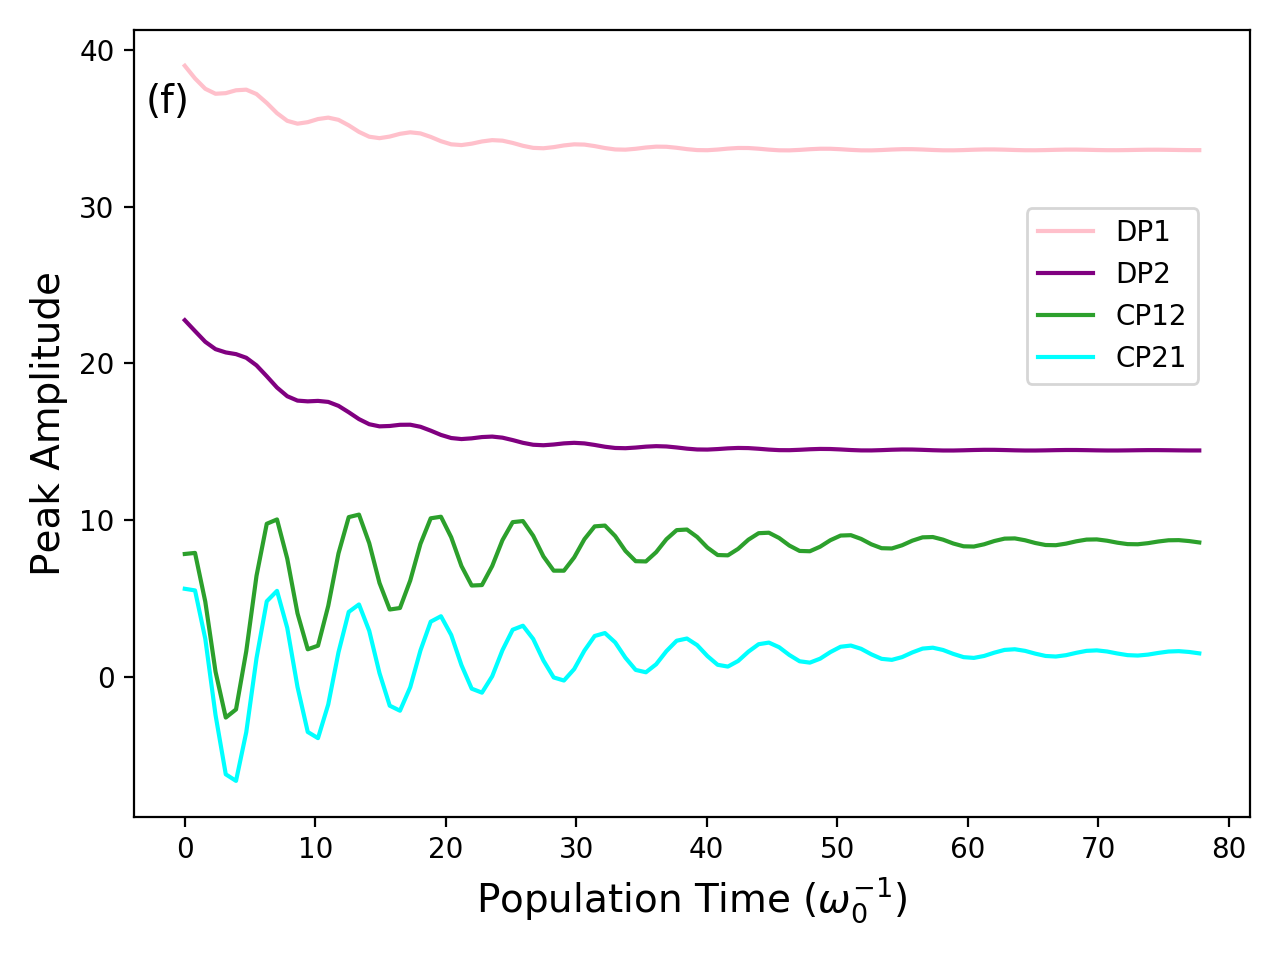

In [32]:
plt.figure()
ind1wt = np.argmin(np.abs(wr+0.5))
ind2wt = np.argmin(np.abs(wr-0.5))
ind1wtau = np.argmin(np.abs(wtaur+0.5))
ind2wtau = np.argmin(np.abs(wtaur-0.5))
plt.plot(T,np.real(tdpe_r_ft[ind1wtau,:,ind1wt]),color='pink')
plt.plot(T,np.real(tdpe_r_ft[ind2wtau,:,ind2wt]),color='purple')
plt.plot(T,np.real(tdpe_r_ft[ind2wtau,:,ind1wt]),color='C2')
plt.plot(T,np.real(tdpe_r_ft[ind1wtau,:,ind2wt]),color='cyan')
plt.legend(['DP1','DP2','CP12','CP21'],loc=(0.8,0.55))
plt.xlabel('Population Time ($\omega_0^{-1}$)',fontsize=14)
plt.ylabel('Peak Amplitude',fontsize=14)
plt.text(-3,36,'(f)',fontsize=14)
plt.tight_layout()

In [33]:
folder_low_temperature = 'vibrationless_dimer_low_temp'
setup_params(folder_low_temperature,0.25)
ufss.HLG.run(folder_low_temperature)
uf2 = ufss.DensityMatrices(os.path.join(folder_low_temperature,'open'))

t0 = time.time()
tdpe_r = calculate_2DPE_r(center=0,sigma=1,gamma=0.025,delay_times=T)
calc_time = time.time() - t0
print(calc_time)
taur = uf2.all_pulse_delays[0].copy()
wr = uf2.w.copy()

1836.1555259227753


<IPython.core.display.Javascript object>


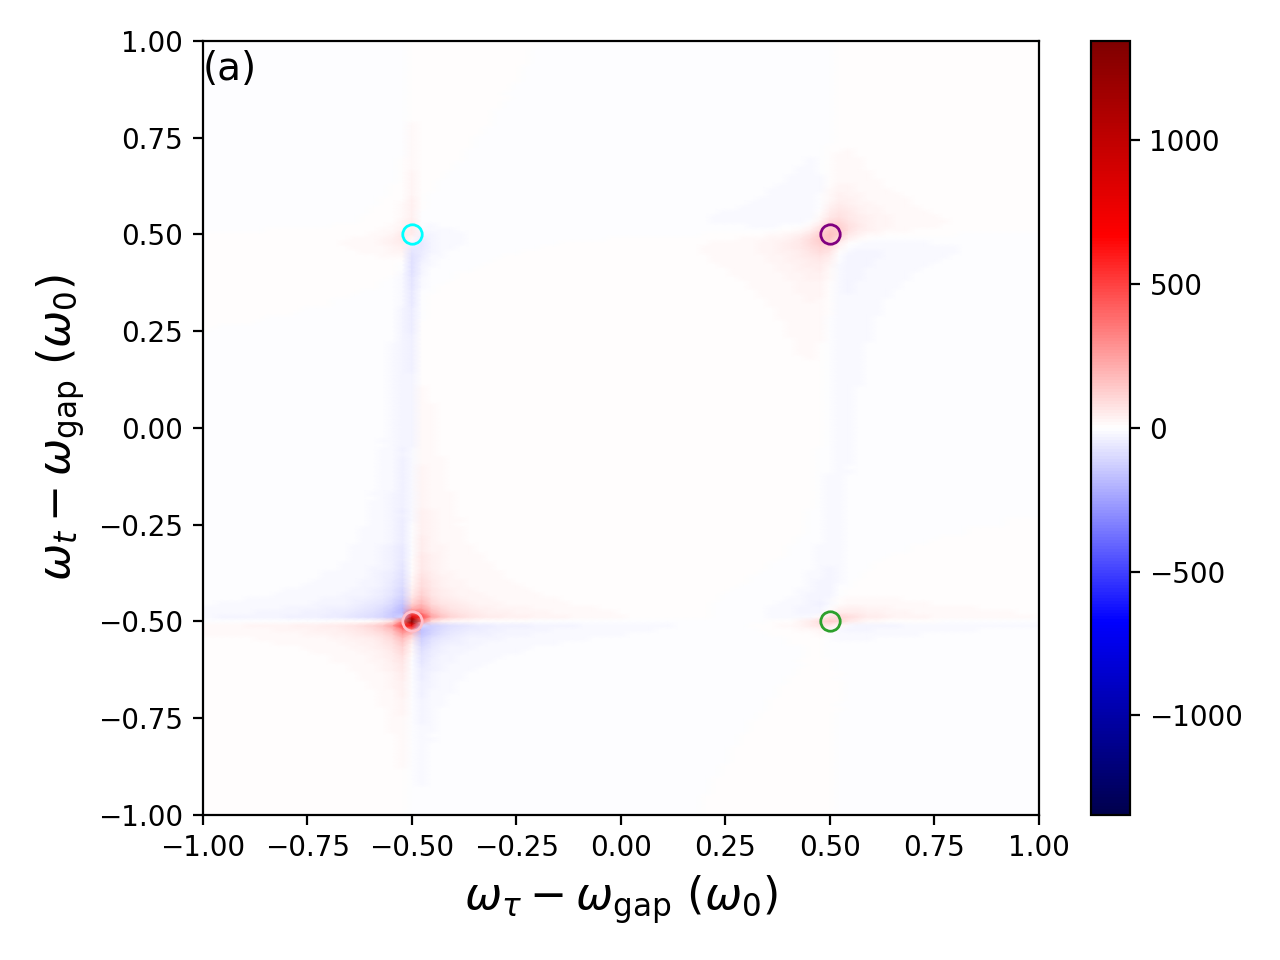

<IPython.core.display.Javascript object>


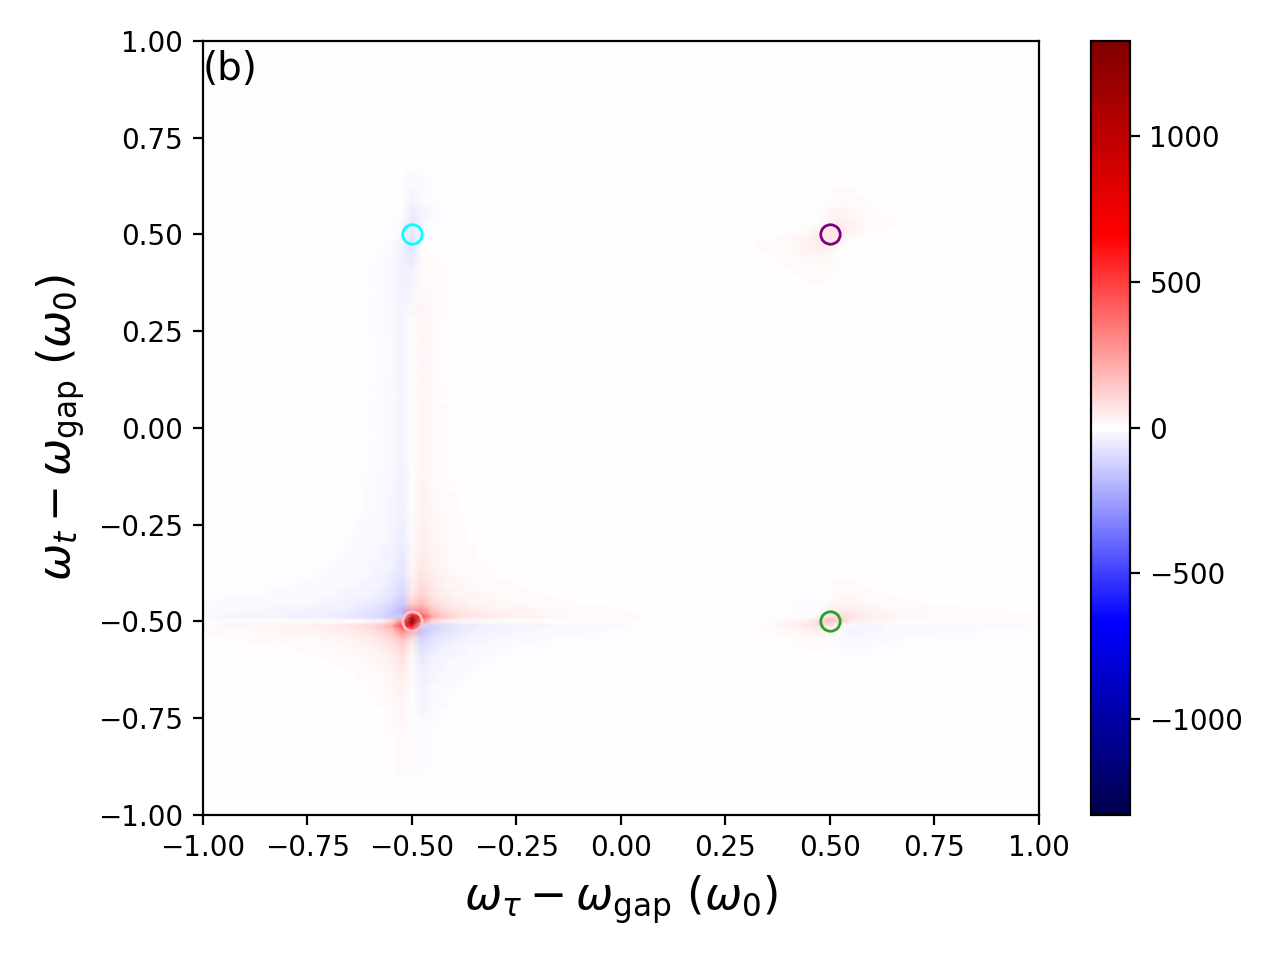

In [34]:
tdpe_r_for_ft = tdpe_r.copy()
tdpe_r_for_ft[0,...] *= 0.5
wtaur, tdpe_r_ft = ufss.signals.SignalProcessing.ft1D(taur,tdpe_r_for_ft,axis=0)

z = tdpe_r_ft
T_ind = 0
ufss.signals.plot2D(wtaur,wr,z[:,T_ind,:],part='real')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.plot(-0.5,-0.5,'o',markersize=7,mfc='None',color='pink')
plt.plot(0.5,0.5,'o',markersize=7,mfc='None',color='purple')
plt.plot(0.5,-0.5,'o',markersize=7,mfc='None',color='C2')
plt.plot(-0.5,0.5,'o',markersize=7,mfc='None',color='cyan')
plt.xlabel(r'$\omega_\tau-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.ylabel('$\omega_t-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.text(-1,0.9,'(a)',fontsize=14)
plt.tight_layout()

T_ind = -1
ufss.signals.plot2D(wtaur,wr,z[:,T_ind,:],part='real')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.plot(-0.5,-0.5,'o',markersize=7,mfc='None',color='pink')
plt.plot(0.5,0.5,'o',markersize=7,mfc='None',color='purple')
plt.plot(0.5,-0.5,'o',markersize=7,mfc='None',color='C2')
plt.plot(-0.5,0.5,'o',markersize=7,mfc='None',color='cyan')
plt.xlabel(r'$\omega_\tau-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.ylabel('$\omega_t-\omega_{\mathrm{gap}}$ ($\omega_0$)',fontsize=16)
plt.text(-1,0.9,'(b)',fontsize=14)
plt.tight_layout()

/Users/prose/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


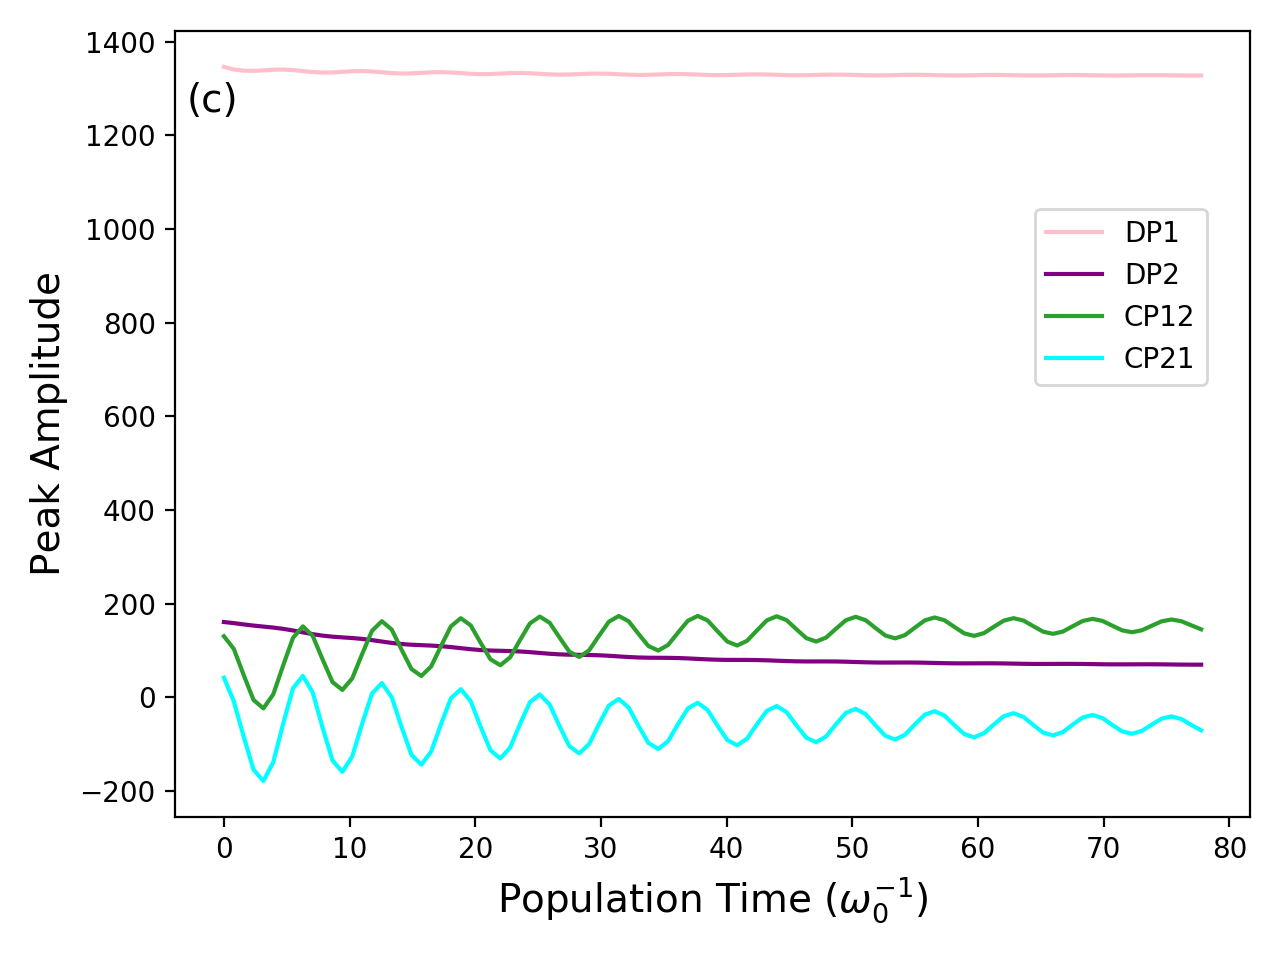

In [35]:
plt.figure()
ind1wt = np.argmin(np.abs(wr+0.5))
ind2wt = np.argmin(np.abs(wr-0.5))
ind1wtau = np.argmin(np.abs(wtaur+0.5))
ind2wtau = np.argmin(np.abs(wtaur-0.5))
plt.plot(T,np.real(tdpe_r_ft[ind1wtau,:,ind1wt]),color='pink')
plt.plot(T,np.real(tdpe_r_ft[ind2wtau,:,ind2wt]),color='purple')
plt.plot(T,np.real(tdpe_r_ft[ind2wtau,:,ind1wt]),color='C2')
plt.plot(T,np.real(tdpe_r_ft[ind1wtau,:,ind2wt]),color='cyan')
plt.legend(['DP1','DP2','CP12','CP21'],loc=(0.8,0.55))
plt.xlabel('Population Time ($\omega_0^{-1}$)',fontsize=14)
plt.ylabel('Peak Amplitude',fontsize=14)
plt.text(-3,1250,'(c)',fontsize=14)
plt.tight_layout()